In [1]:
import numpy as np
import pylab as plt
from bioscrape.lineage import LineageModel
from bioscrape.lineage import LineageVolumeSplitter
from bioscrape.lineage import py_SimulateInteractingCellLineage
from bioscrape.lineage import py_SimulateSingleCell

species = ["Abx", "aux"]
kC, KC = .5, 10
D, d = .02, .01
kaux, daux = 10., .1
kAbx, KAbx = 5, 10
parameters = [("kC", kC), ("KC", KC), ("D", D), ("d", d), ("kaux", kaux), ("daux", daux), ("kAbx", kAbx), ("KAbx", KAbx)]
x0 = {"Abx":0, "aux":0}
rxn1 = ([], ["Abx"], "hillpositive", {"k":"kAbx", "K":"KAbx", "s1":"aux", "n":2}) # 0 --> Abx
rxn2 = (["Abx"], [], "massaction", {"k":"d"}) #Abx --> 0
rxn3 = ([], ["aux"], "general", {"rate":"_kaux"}) #0 --> aux
rxn4 = (["aux"], [], "massaction", {"k":"daux"}) #aux --> 0
reactions = [rxn1, rxn2, rxn3, rxn4]
M1 = LineageModel(species = species, parameters = parameters, reactions = reactions, initial_condition_dict = x0)
M1.create_volume_rule("ode", {"equation": "_kC*1/(1+(Abx/_KC)^2)"})
M1.create_division_rule("deltaV", {"threshold":1}, LineageVolumeSplitter(M1))
M1.create_death_event("death", {}, "general", {"rate":"_D"})


In [29]:
timepoints = np.arange(0, 100, .001)
global_sync_period = 2.0
N = 5

lineage = py_SimulateInteractingCellLineage(timepoints, global_sync_period, models = [M1], initial_cell_states = [N], global_species = ["aux"], global_species_method = 3)

print("lineages returned:", lineage.py_size())

lineages returned: 99


In [30]:
sch_tree = [[]]
sch_tree_length = 1
for i in range(lineage.py_size()):
	sch = lineage.py_get_schnitz(i)
	if sch.py_get_parent() == None:
		sch_tree[0].append(sch)
	else:
		for j in range(len(sch_tree)):
			parent = sch.py_get_parent()
			if parent in sch_tree[j]:
				if len(sch_tree)<= j+1:
					sch_tree.append([])
					sch_tree_length += 1
				sch_tree[j+1].append(sch)

color_list = []
for i in range(sch_tree_length):
	color_list.append((i/sch_tree_length, 0, 1.-i/sch_tree_length))

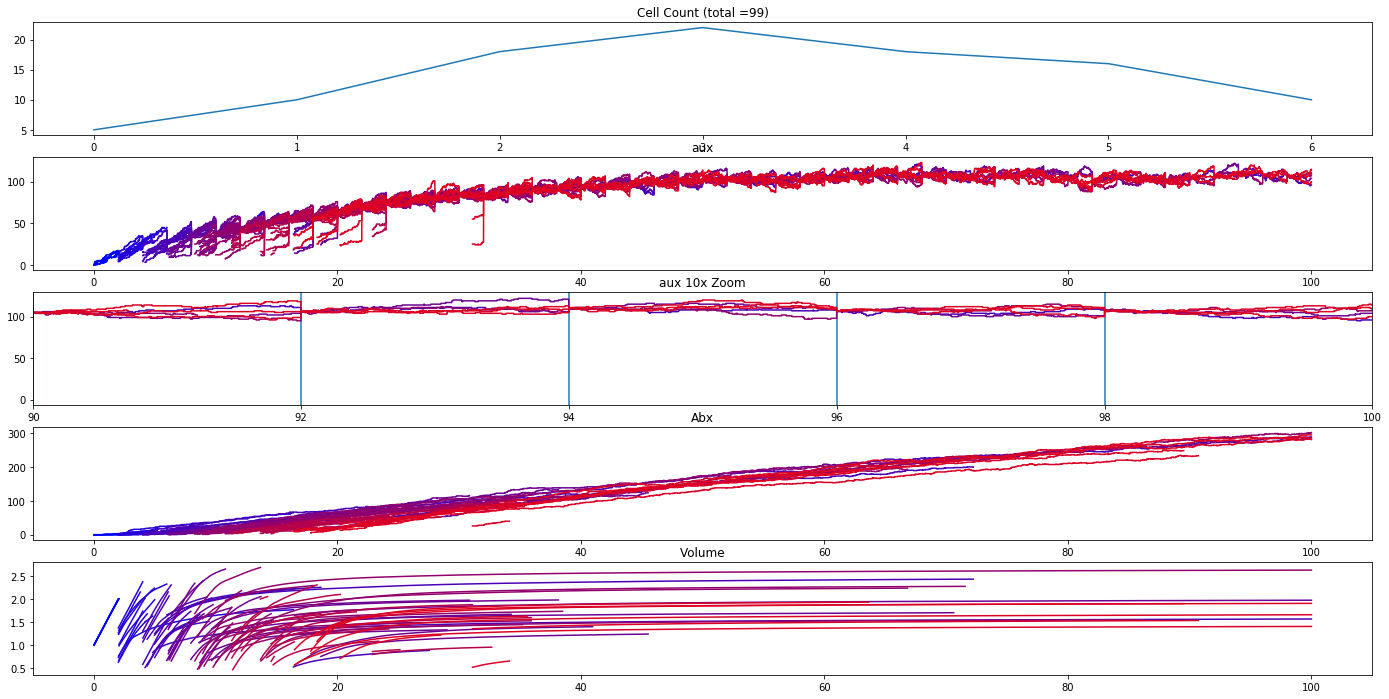

In [31]:
plt.figure(figsize = (24, 12))

plt.subplot(511)
counts = [len(sch_list) for sch_list in sch_tree]
plt.plot(range(len(counts)), counts)
plt.title("Cell Count (total ="+str(sum(counts))+")")
plt.xlabel("Generation")

plt.subplot(512)
plt.title("aux")
for i in range(sch_tree_length):
    for sch in sch_tree[i]:
        df = sch.py_get_dataframe(Model = M1)
        plt.plot(df["time"], df["aux"], color = color_list[i])
        
plt.subplot(513)
plt.title("aux 10x Zoom")
for i in np.arange(0, timepoints[-1], global_sync_period):
    plt.axvline(i)
    
for i in range(sch_tree_length):
    for sch in sch_tree[i]:
        df = sch.py_get_dataframe(Model = M1)
        plt.plot(df["time"][-len(df["time"]):], df["aux"][-len(df["time"]):], color = color_list[i])
plt.xlim(timepoints[-1]*.9, timepoints[-1])

plt.subplot(514)
plt.title("Abx")
for i in range(sch_tree_length):
    for sch in sch_tree[i]:
        df = sch.py_get_dataframe(Model = M1)
        plt.plot(df["time"], df["Abx"], color = color_list[i])


plt.subplot(515)
plt.title("Volume")
for i in range(sch_tree_length):
    for sch in sch_tree[i]:
        df = sch.py_get_dataframe(Model = M1)
        plt.plot(df["time"], df["volume"], color = color_list[i])



plt.show()